In [9]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Data Preparation
train_dir = "../../data4/train"
validation_dir = "../../data4/validation"
batch_size = 32
image_size = (224, 224)

# Augment training data and rescale
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,       # Random rotation
    zoom_range=0.3,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    brightness_range=[0.8, 1.2],  # Random brightness
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shearing
    fill_mode="nearest"      # Fill empty pixels
)

# Only rescale validation data
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'  # Changed to 'categorical' for multi-class classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Extract number of classes
num_classes = train_generator.num_classes


Found 5999 images belonging to 4 classes.
Found 1672 images belonging to 4 classes.


In [11]:
# Standalone ResNet50 Model
def build_resnet50_model(num_classes):
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    resnet_base.trainable = False  # Freeze base model

    input_tensor = Input(shape=(224, 224, 3))
    x = resnet_base(input_tensor)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = build_resnet50_model(num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

In [ ]:
# Train the ResNet50 Model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the trained model
model.save("../../models/Improved_resnet50_model.keras")

Epoch 1/20


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


182/188 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - AUC: 0.6798 - accuracy: 0.4230 - loss: 1.3138

53/53 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - AUC: 0.8511 - accuracy: 0.6221 - loss: 0.9236
Validation Loss: 0.92
Validation Accuracy: 0.63
53/53 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.27      0.34      0.30       450
      2. Ekzama       0.25      0.24      0.25       450
        3. Akne       0.22      0.21      0.21       322
      4. Malign       0.27      0.22      0.24       450

       accuracy                           0.26      1672
      macro avg       0.25      0.25      0.25      1672
   weighted avg       0.25      0.26      0.25      1672

[[152 114  88  96]
 [159 107  78 106]
 [103  80  69  70]
 [146 120  85  99]]


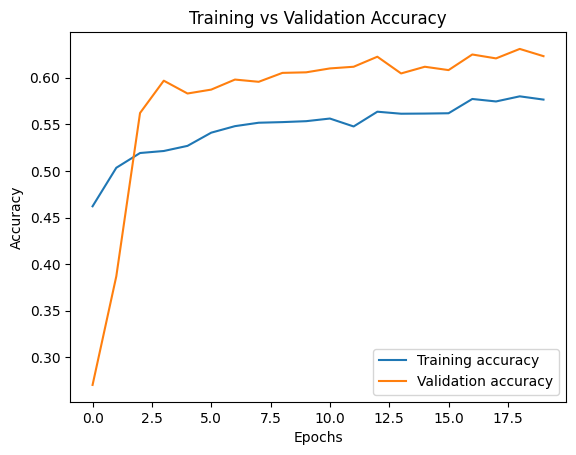

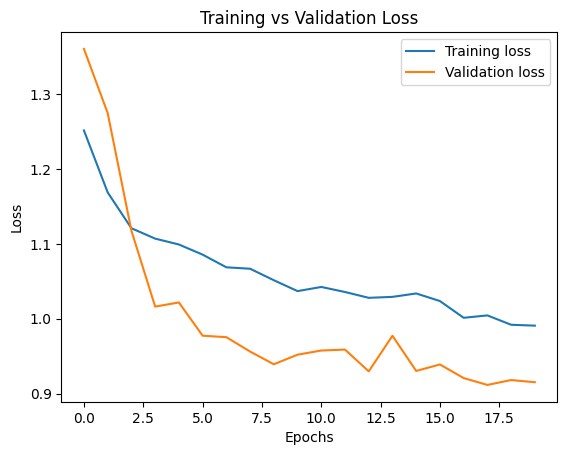

In [ ]:
# Evaluate the ResNet50 Model
results = model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]:.2f}")
print(f"Validation Accuracy: {results[1]:.2f}")

# Classification report and confusion matrix
val_preds = np.argmax(model.predict(validation_generator), axis=1)
true_labels = validation_generator.classes
print(classification_report(true_labels, val_preds, target_names=validation_generator.class_indices.keys()))
print(confusion_matrix(true_labels, val_preds))

# Plot training and validation curves
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(history, metrics=["accuracy", "loss"])

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 622s 3s/step - AUC: 0.7108 - accuracy: 0.4521 - loss: 1.7117 - val_AUC: 0.5412 - val_accuracy: 0.2781 - val_loss: 16.2157 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 611s 3s/step - AUC: 0.7851 - accuracy: 0.5225 - loss: 1.1005 - val_AUC: 0.6290 - val_accuracy: 0.3786 - val_loss: 4.7791 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 604s 3s/step - AUC: 0.7998 - accuracy: 0.5483 - loss: 1.0734 - val_AUC: 0.5838 - val_accuracy: 0.3331 - val_loss: 6.5426 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 602s 3s/step - AUC: 0.8095 - accuracy: 0.5733 - loss: 1.0306 - val_AUC: 0.5774 - val_accuracy: 0.3158 - val_loss: 9.3670 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 600s 3s/step - AUC: 0.8156 - accuracy: 0.5725 - loss: 1.0194 - val_AUC: 0.5322 - val_accuracy: 0.2500 - val_loss: 7.9585 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 607s 3s/step -

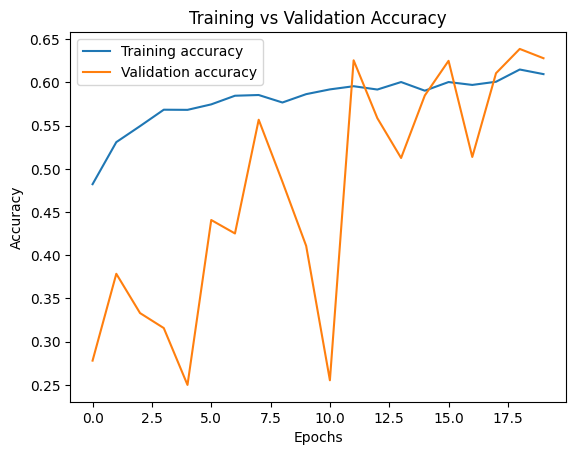

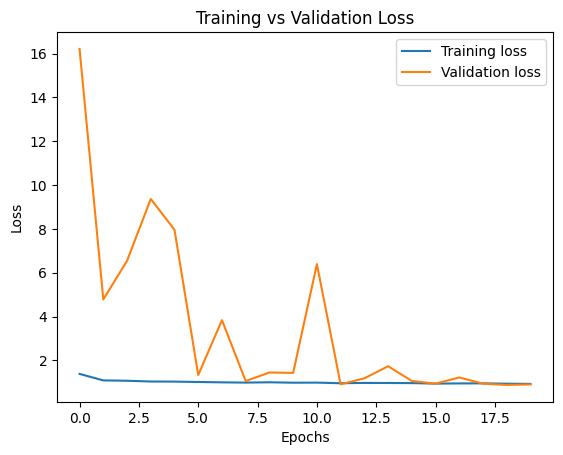

In [ ]:
# Unfreeze the last few layers for fine-tuning
resnet_base = model.get_layer("resnet50")
for layer in resnet_base.layers[-15:]:  # Unfreezing more layers for better adaptability
    layer.trainable = True
    
# Fine-tune the model with improved parameters
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    batch_size=32,  # Use a larger batch size for better gradient estimates
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),  # Adjust patience for stability
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)  # Focus on loss for stability
    ]
)

# Save the trained model
model.save("../../models/Improved_resnet50_model.keras")
# Plot training results
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(fine_tune_history, metrics=["accuracy", "loss"])


In [ ]:
# Evaluate the ResNet50 Model
results = model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]:.2f}")
print(f"Validation Accuracy: {results[1]:.2f}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - AUC: 0.8745 - accuracy: 0.6431 - loss: 0.8486
Validation Loss: 0.88
Validation Accuracy: 0.64
